In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import anndata
import scvelo as scv
import scanpy as sc

from scipy.sparse import csr_matrix
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.neighbors import kneighbors_graph
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from RnaVeloDataset import RnaVeloDataset
from symsimDataset import SymsimBifur, SymsimTree, SymsimBranch, SymsimLinear, SymsimCycle

from symsimDatasetTest import SymsimTreeNoisy, SymsimBifurNoisy, SymsimLinearNoisy

from realDataset import forebrainDataset, chromaffinDataset, forebrainDataset_large, peDataset, peDataset_large

from unsupervised_loss import UnsupervisedLoss

import torch
import torch.nn.functional as F
import torch.nn as nn
from sklearn.metrics import roc_auc_score
from torch_geometric.data import DataLoader
from model.BaseModel import BaseModel
from sklearn.metrics import mean_squared_error
from model.autoencoder import AutoEncoder

from model.mymodel import MyModel, GraphSAGEModel, FCModel, veloModel, DiffusionModel


from math import sqrt
import scprep
import utils
import backbone

from torch_geometric.data import Data

In [2]:
dataBifur = SymsimBifur()
dataTree = SymsimTree()
# datalinear = SymsimLinear()
dataDyngen = RnaVeloDataset()
forebrain = forebrainDataset()
forebrain_large = forebrainDataset_large()
chromaffin = chromaffinDataset()
pancreas = peDataset()
pancreas_large = peDataset_large()

dataTreeNoisy = SymsimTreeNoisy()


Processing...
Filtered out 20801 genes that are detected in less than 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
Trying to set attribute `.uns` of view, copying.
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
... 100%    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 1 region of root cells and 1 region of end points 
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion proc

In [3]:
t = np.arange(1,10)

# dataset for validation
val_mask = [10*i for i in range(4)]

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Path = "./trained_model/Diffusion_liear_only.pt"
# Path = "./Diffusion_symsim_tree_bifur_trifur.pt"

model = DiffusionModel(dataBifur.num_features, hidden1 = 128, hidden2 = 64, max_diffusion = 10, include_reversed = True, device = device, dropout1=0.4, dropout2=0.2).to(device)

model.load_state_dict(torch.load(Path, map_location=torch.device('cpu')))
model.eval()

DiffusionModel(
  (conv1): GraphDiffusion (300 -> 128)
  (conv2): GraphDiffusion (128 -> 64)
  (lin): Linear(in_features=64, out_features=1, bias=True)
  (relu1): LeakyReLU(negative_slope=0.1)
  (relu2): LeakyReLU(negative_slope=0.1)
)

# Noiseless dataset

pearson corr: 0.724591122815461 , kendall tau: 0.6518436581525225
pearson corr: 0.6793486443536029 , kendall tau: 0.6617754301915841
pearson corr: 0.6210949981775868 , kendall tau: 0.6475026777823313
pearson corr: 0.7174191275599554 , kendall tau: 0.6158498533009463


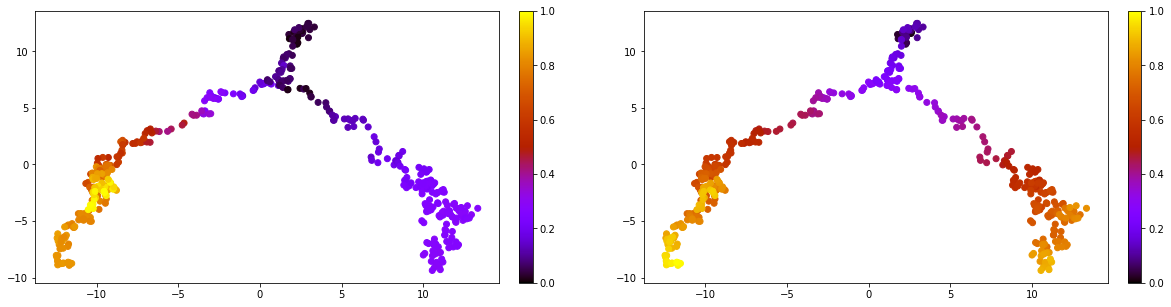

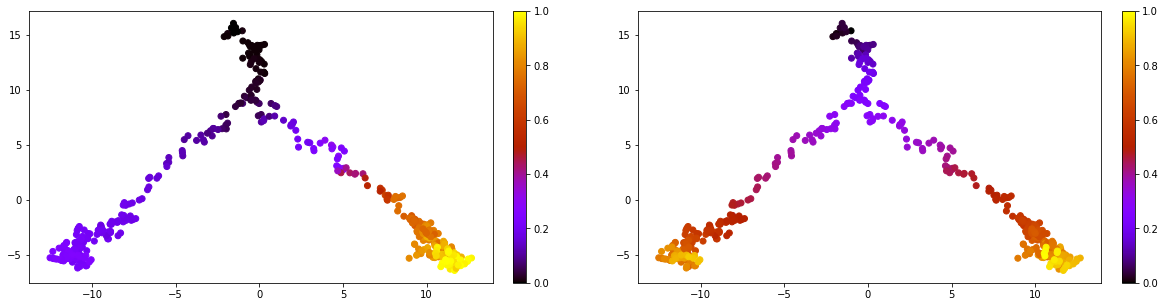

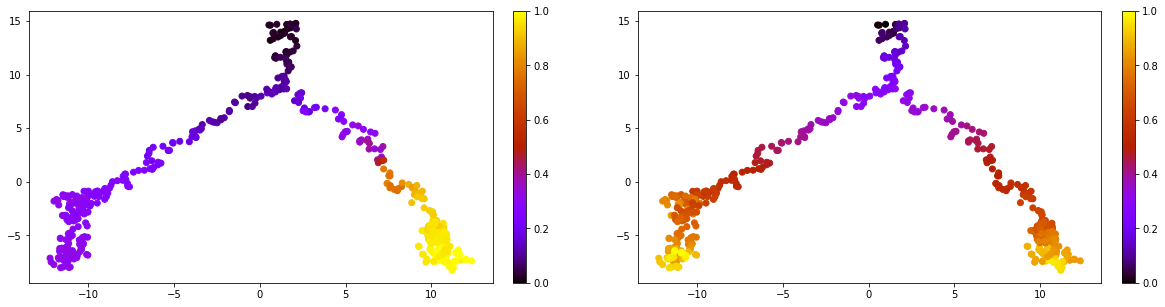

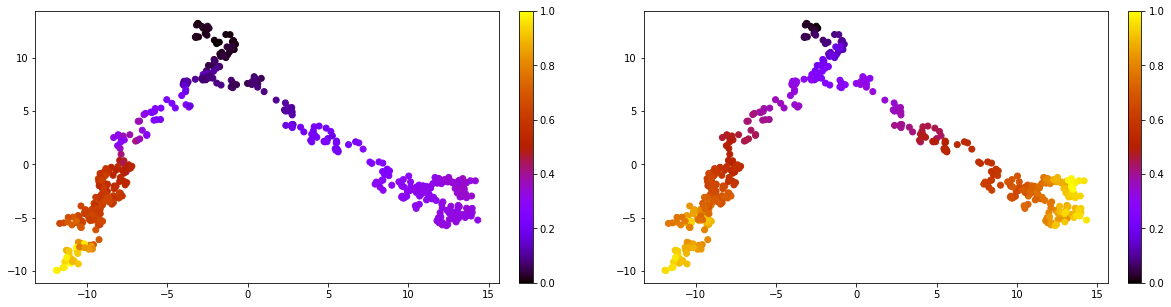

In [5]:
for idx, data in enumerate(DataLoader(dataTree[val_mask])):
    pt = data.y_vdpt[0]
    X_pca = utils.pca_op(data.x.detach().numpy())
    fig = plt.figure(figsize = (20, 5))
    ax1, ax2 = fig.subplots(1,2)
    pseudo_visual = ax1.scatter(X_pca[:,0], X_pca[:,1], c = pt, cmap = plt.get_cmap('gnuplot'))
    fig.colorbar(pseudo_visual,fraction=0.046, pad=0.04, ax = ax1)

    pt_true = data.y.cpu().numpy().squeeze()
    pseudo_visual = ax2.scatter(X_pca[:,0], X_pca[:,1], c = pt_true, cmap = plt.get_cmap('gnuplot'))
    fig.colorbar(pseudo_visual,fraction=0.046, pad=0.04, ax = ax2)

    vx = pt - np.mean(pt)
    vy = pt_true - np.mean(pt_true)
    pearson = np.sum(vx * vy) / (np.sqrt(np.sum(vx ** 2)) * np.sqrt(np.sum(vy ** 2)))
    kt = utils.kendalltau(pt, pt_true)
    print('pearson corr:',pearson,', kendall tau:',kt)

pearson corr: 0.5622493 , kendall tau: 0.39549156564169813
pearson corr: 0.8477678 , kendall tau: 0.6379009608277901
pearson corr: 0.9459245 , kendall tau: 0.7892840916466541
pearson corr: 0.9003366 , kendall tau: 0.6760121730421048


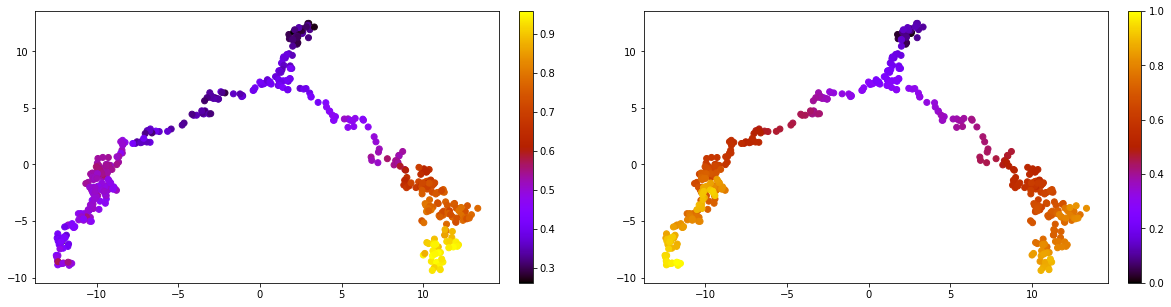

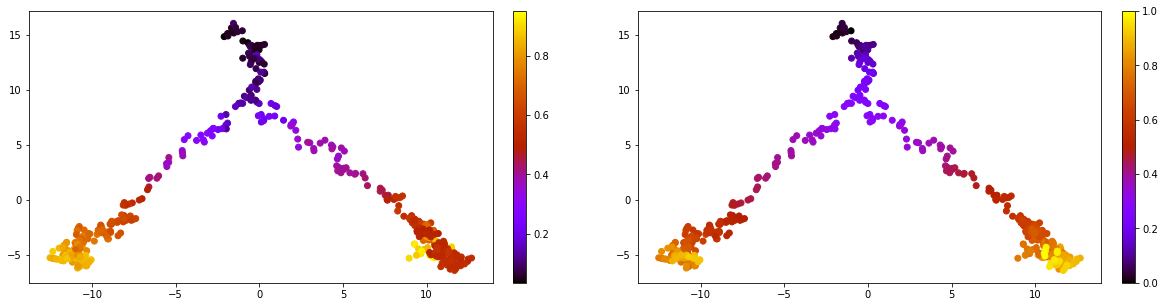

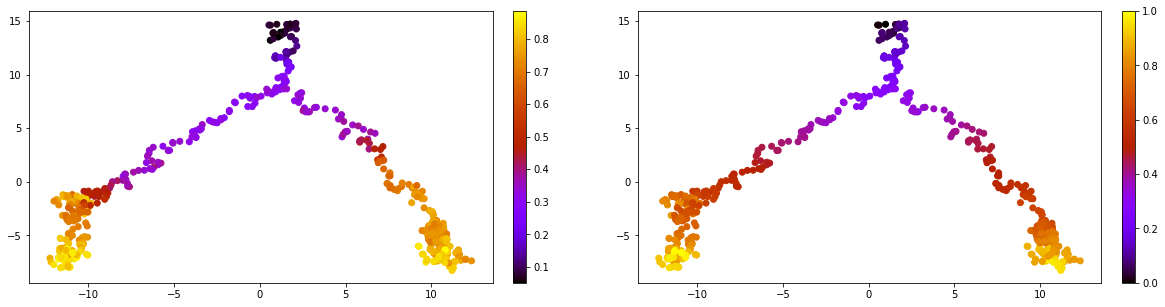

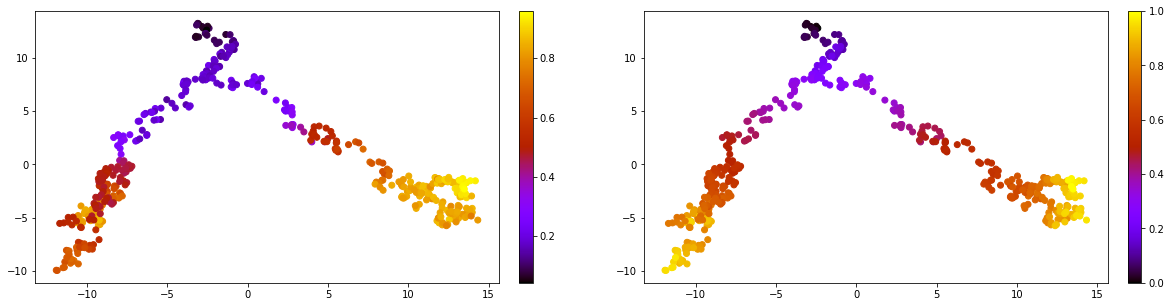

In [6]:
for idx, data in enumerate(DataLoader(dataTree[val_mask])):
    X_pca = utils.pca_op(data.x.detach().numpy(), standardize=False)

    pt, _, _ = model(data.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
    pt = pt.detach().cpu().numpy().reshape(-1)
    fig = plt.figure(figsize = (20, 5))
    ax1, ax2 = fig.subplots(1,2)
    pseudo_visual = ax1.scatter(X_pca[:,0], X_pca[:,1], c = pt, cmap = plt.get_cmap('gnuplot'))
    fig.colorbar(pseudo_visual,fraction=0.046, pad=0.04, ax = ax1)

    pt_true = data.y.cpu().numpy().squeeze()
    pseudo_visual = ax2.scatter(X_pca[:,0], X_pca[:,1], c = pt_true, cmap = plt.get_cmap('gnuplot'))
    fig.colorbar(pseudo_visual,fraction=0.046, pad=0.04, ax = ax2)

    vx = pt - np.mean(pt)
    vy = pt_true - np.mean(pt_true)
    pearson = np.sum(vx * vy) / (np.sqrt(np.sum(vx ** 2)) * np.sqrt(np.sum(vy ** 2)))
    kt = utils.kendalltau(pt, pt_true)
    print('pearson corr:',pearson,', kendall tau:',kt)

# Noisy dataset

pearson corr: -0.11746000723020149 , kendall tau: -0.07698343140937357
pearson corr: -0.08891877872168309 , kendall tau: -0.07053962689370227
pearson corr: -0.08481340296279179 , kendall tau: 0.000141897249697425
pearson corr: -0.5200158390277116 , kendall tau: -0.44898793873377574


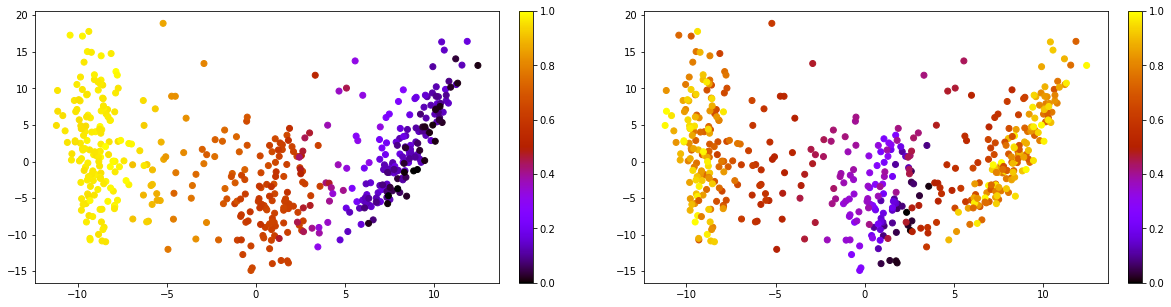

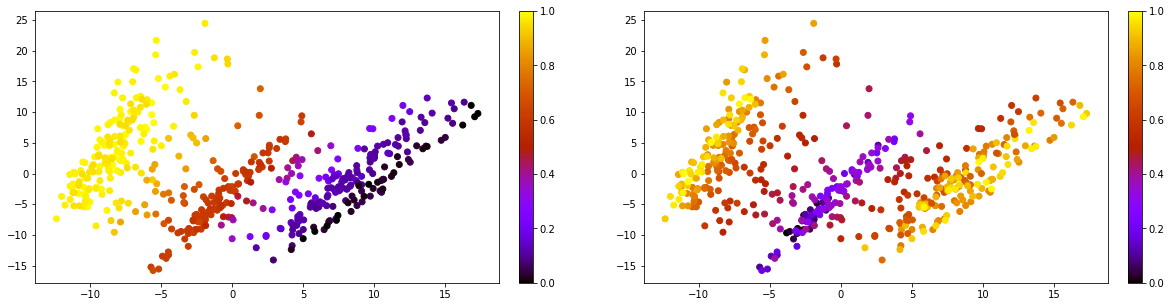

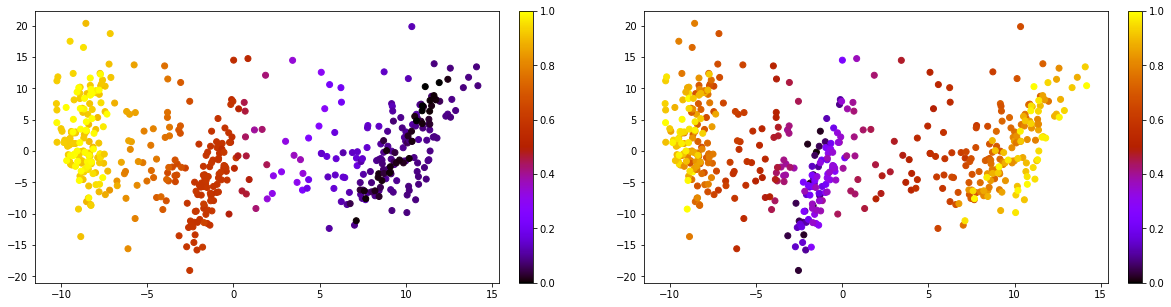

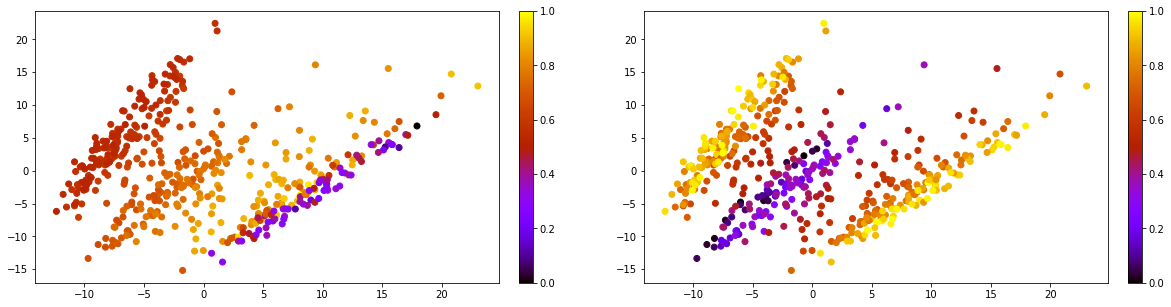

In [7]:
for idx, data in enumerate(DataLoader(dataTreeNoisy[val_mask])):
    pt = data.y_vdpt[0]
    X_pca = utils.pca_op(data.x.detach().numpy())
    fig = plt.figure(figsize = (20, 5))
    ax1, ax2 = fig.subplots(1,2)
    pseudo_visual = ax1.scatter(X_pca[:,0], X_pca[:,1], c = pt, cmap = plt.get_cmap('gnuplot'))
    fig.colorbar(pseudo_visual,fraction=0.046, pad=0.04, ax = ax1)

    pt_true = data.y.cpu().numpy().squeeze()
    pseudo_visual = ax2.scatter(X_pca[:,0], X_pca[:,1], c = pt_true, cmap = plt.get_cmap('gnuplot'))
    fig.colorbar(pseudo_visual,fraction=0.046, pad=0.04, ax = ax2)

    vx = pt - np.mean(pt)
    vy = pt_true - np.mean(pt_true)
    pearson = np.sum(vx * vy) / (np.sqrt(np.sum(vx ** 2)) * np.sqrt(np.sum(vy ** 2)))
    kt = utils.kendalltau(pt, pt_true)
    print('pearson corr:',pearson,', kendall tau:',kt)

pearson corr: 0.7575386 , kendall tau: 0.5033596260590125
pearson corr: 0.75831366 , kendall tau: 0.4965819456617003
pearson corr: 0.55725884 , kendall tau: 0.3977379909018822
pearson corr: 0.637603 , kendall tau: 0.4519594340803807


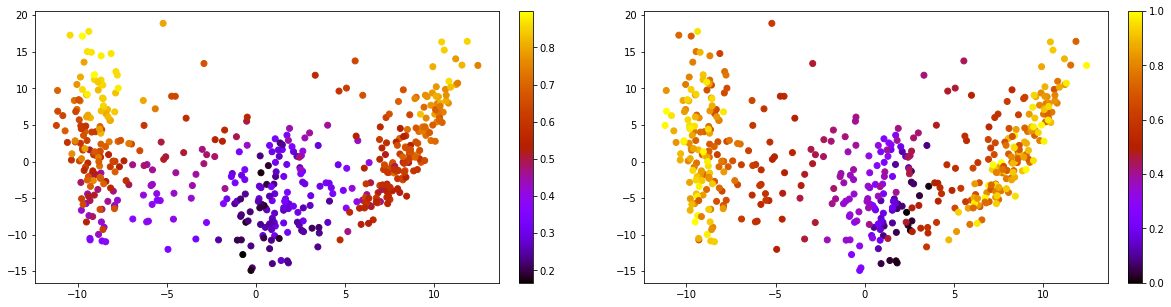

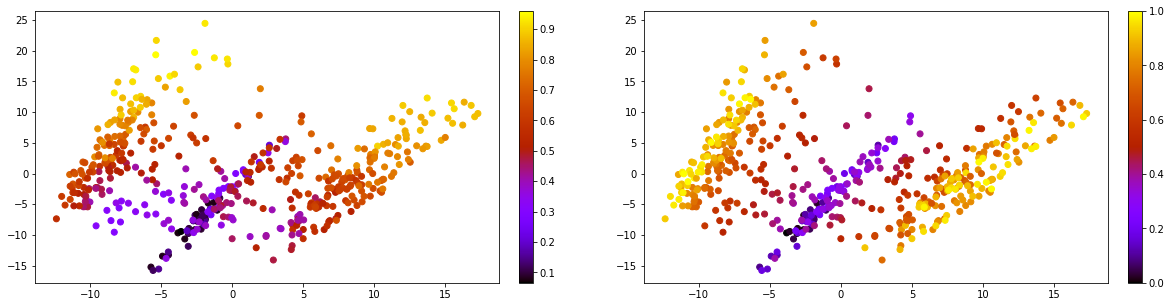

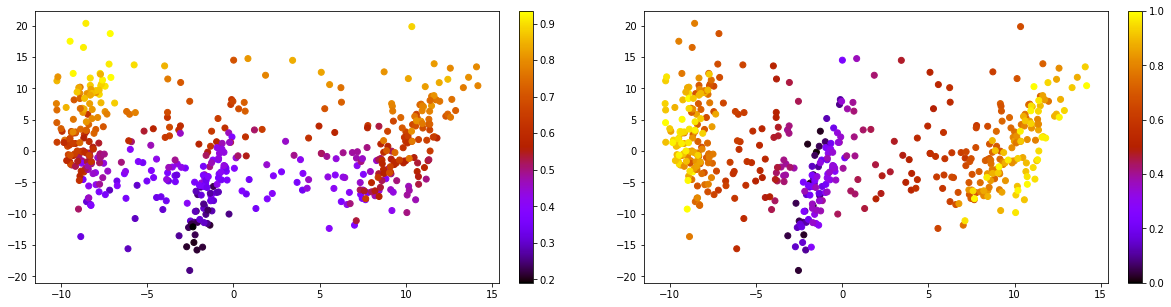

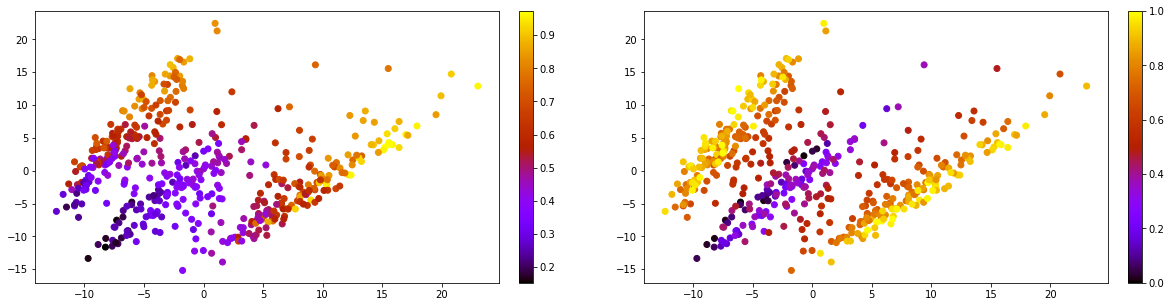

In [8]:
for idx, data in enumerate(DataLoader(dataTreeNoisy[val_mask])):
    X_pca = utils.pca_op(data.x.detach().numpy(), standardize=False)

    pt, _, _ = model(data.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
    pt = pt.detach().cpu().numpy().reshape(-1)
    fig = plt.figure(figsize = (20, 5))
    ax1, ax2 = fig.subplots(1,2)
    pseudo_visual = ax1.scatter(X_pca[:,0], X_pca[:,1], c = pt, cmap = plt.get_cmap('gnuplot'))
    fig.colorbar(pseudo_visual,fraction=0.046, pad=0.04, ax = ax1)

    pt_true = data.y.cpu().numpy().squeeze()
    pseudo_visual = ax2.scatter(X_pca[:,0], X_pca[:,1], c = pt_true, cmap = plt.get_cmap('gnuplot'))
    fig.colorbar(pseudo_visual,fraction=0.046, pad=0.04, ax = ax2)

    vx = pt - np.mean(pt)
    vy = pt_true - np.mean(pt_true)
    pearson = np.sum(vx * vy) / (np.sqrt(np.sum(vx ** 2)) * np.sqrt(np.sum(vy ** 2)))
    kt = utils.kendalltau(pt, pt_true)
    print('pearson corr:',pearson,', kendall tau:',kt)

# Dyngen dataset

pearson corr: -0.72701794 , kendall tau: -0.5959975001787139
pearson corr: -0.81764495 , kendall tau: -0.8059845380468676
pearson corr: -0.8208137 , kendall tau: -0.6739935412008613
pearson corr: -0.7736969 , kendall tau: -0.6151342340239365
pearson corr: -0.8588343 , kendall tau: -0.8107818589250395
pearson corr: -0.9072489 , kendall tau: -0.7831184318520004
pearson corr: -0.79387456 , kendall tau: -0.7545738420737859
pearson corr: -0.80869555 , kendall tau: -0.6543274137335847
pearson corr: -0.9243688 , kendall tau: -0.7714897599945424
pearson corr: -0.88367087 , kendall tau: -0.802259928022648
pearson corr: -0.8617517 , kendall tau: -0.7459919657863415


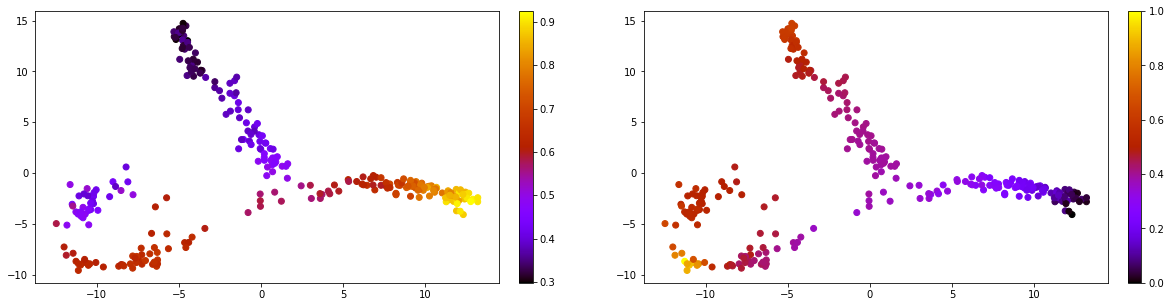

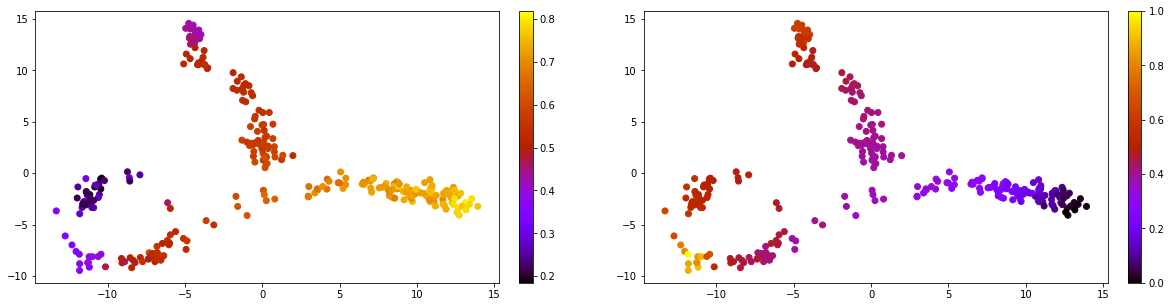

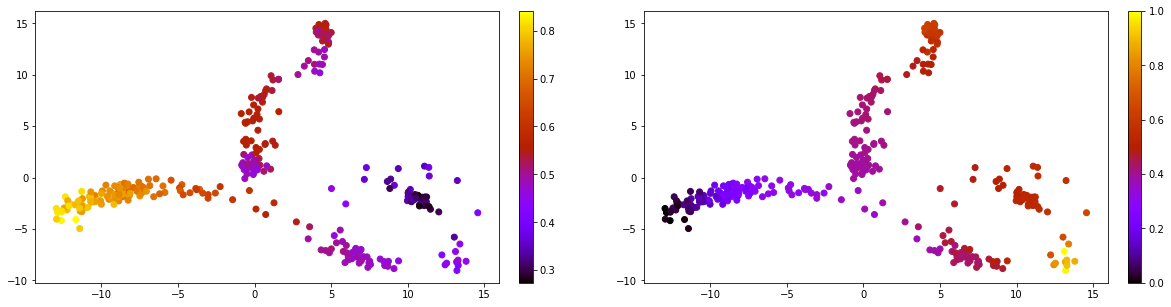

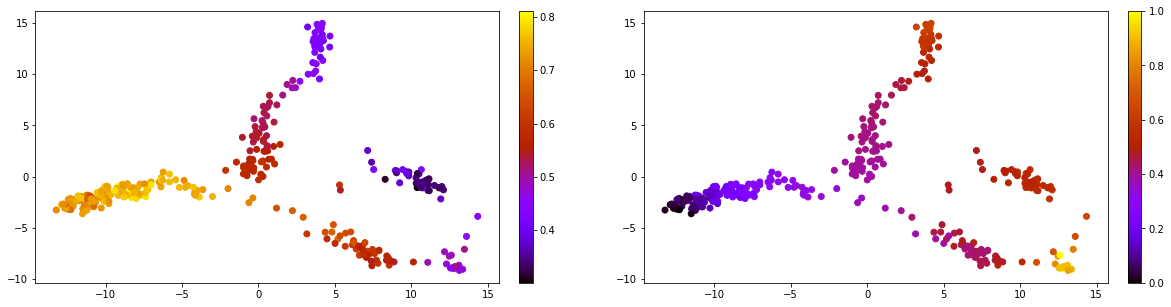

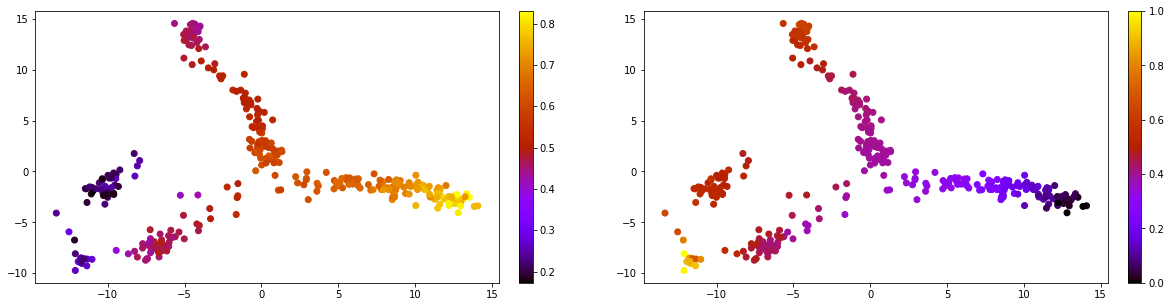

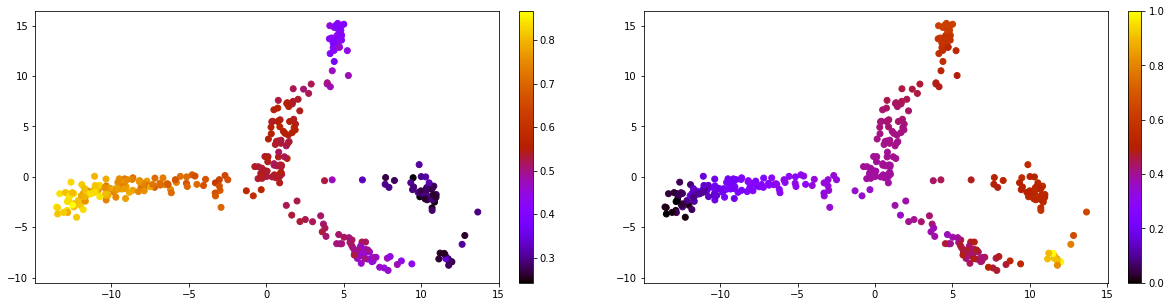

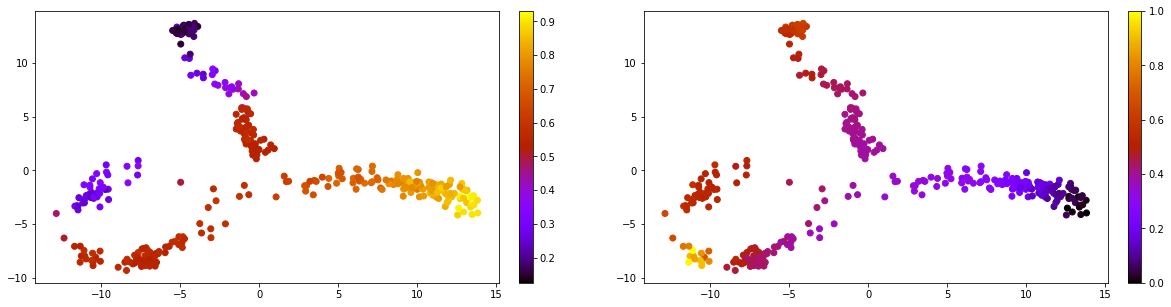

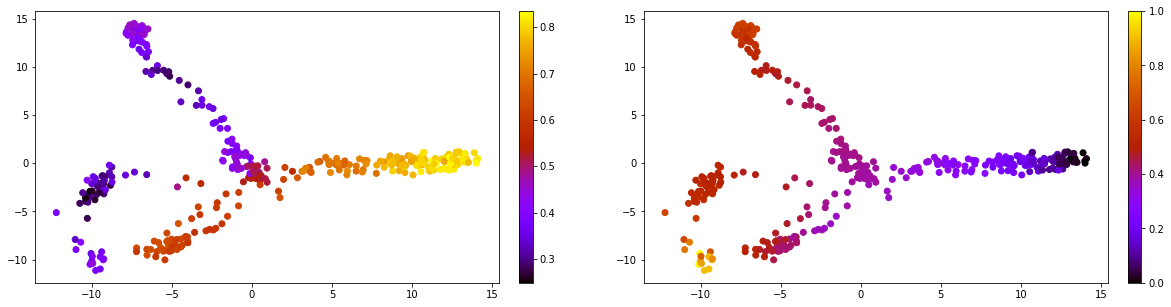

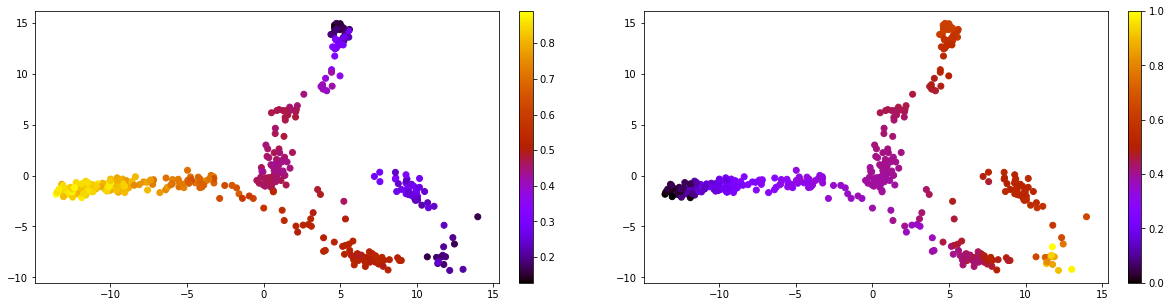

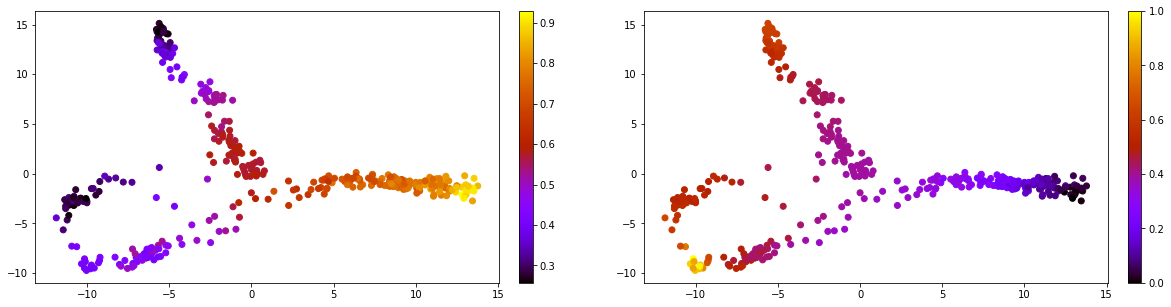

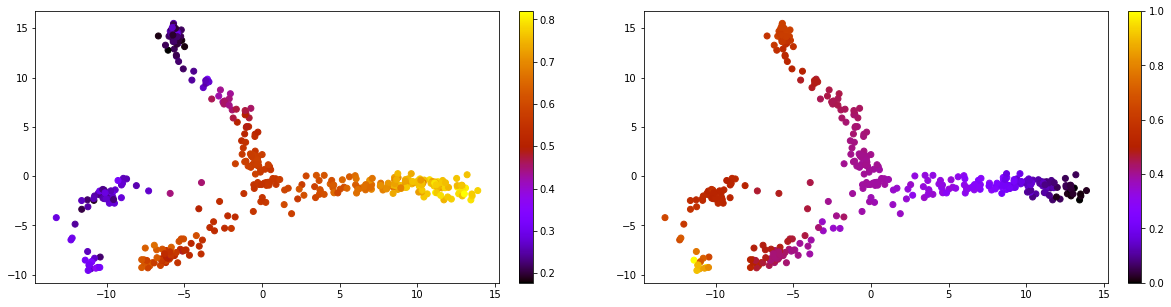

In [5]:
for idx, data in enumerate(DataLoader(dataDyngen)):
    X_pca = utils.pca_op(data.x.detach().numpy(), standardize=False)
    
    pt, _, _ = model(data.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
    pt = pt.detach().cpu().numpy().reshape(-1)
    fig = plt.figure(figsize = (20, 5))
    ax1, ax2 = fig.subplots(1,2)
    pseudo_visual = ax1.scatter(X_pca[:,0], X_pca[:,1], c = pt, cmap = plt.get_cmap('gnuplot'))
    fig.colorbar(pseudo_visual,fraction=0.046, pad=0.04, ax = ax1)

    pt_true = data.y.cpu().numpy().squeeze()
    pseudo_visual = ax2.scatter(X_pca[:,0], X_pca[:,1], c = pt_true, cmap = plt.get_cmap('gnuplot'))
    fig.colorbar(pseudo_visual,fraction=0.046, pad=0.04, ax = ax2)

    vx = pt - np.mean(pt)
    vy = pt_true - np.mean(pt_true)
    pearson = np.sum(vx * vy) / (np.sqrt(np.sum(vx ** 2)) * np.sqrt(np.sum(vy ** 2)))
    kt = utils.kendalltau(pt, pt_true)
    print('pearson corr:',pearson,', kendall tau:',kt)

# Real dataset

(574,)


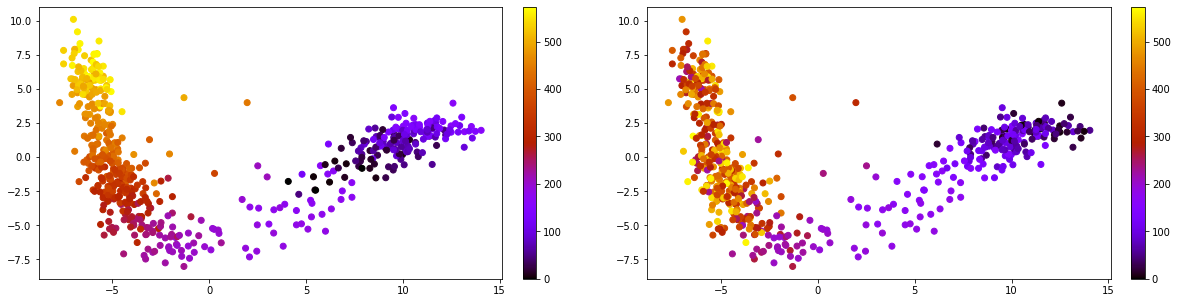

In [12]:
for idx, data in enumerate(DataLoader(forebrain)):
    pt = data.y_vdpt[0].squeeze()
    print(pt.shape)

    # pt = np.argsort(pt)
    X_pca = utils.pca_op(data.x.detach().numpy(), standardize=False)
    fig = plt.figure(figsize = (20, 5))
    ax1,ax2 = fig.subplots(1,2)
    
    pred_sorted = sorted(pt)
    pt = [pred_sorted.index(i) for i in pt]

    pseudo_visual = ax1.scatter(X_pca[:,0], X_pca[:,1], c = pt, cmap = plt.get_cmap('gnuplot'))
    fig.colorbar(pseudo_visual,fraction=0.046, pad=0.04, ax = ax1)

    pt, _, _ = model(data.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
    pt = pt.detach().numpy().squeeze()

    pred_sorted = sorted(pt)
    pt = [pred_sorted.index(i) for i in pt]
    # pt = (pt - np.min(pt))/(np.max(pt)-np.min(pt))
    # print(len(pt))
    # pt = np.argsort(pt)
    
    pseudo_visual = ax2.scatter(X_pca[:,0], X_pca[:,1], c = pt, cmap = plt.get_cmap('gnuplot'))
    fig.colorbar(pseudo_visual,fraction=0.046, pad=0.04, ax = ax2)    

    

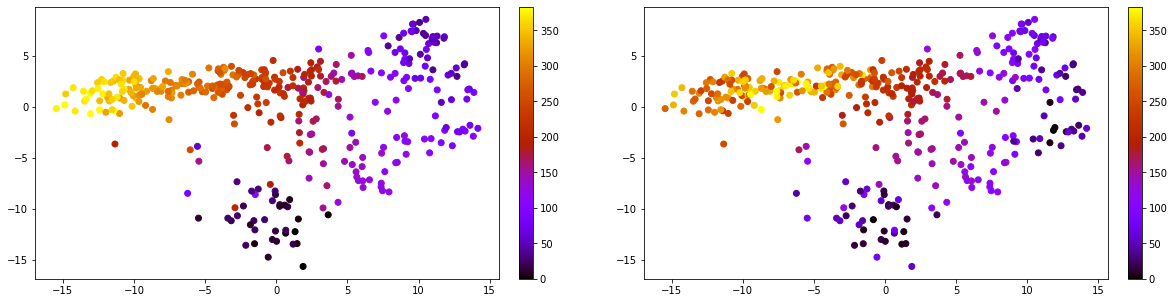

In [13]:
for idx, data in enumerate(DataLoader(chromaffin)):
    pt = data.y_vdpt[0].squeeze()

    # pt = np.argsort(pt)
    X_pca = utils.pca_op(data.x.detach().numpy(), standardize=False)
    fig = plt.figure(figsize = (20, 5))
    ax1,ax2 = fig.subplots(1,2)
    
    pred_sorted = sorted(pt)
    pt = [pred_sorted.index(i) for i in pt]

    pseudo_visual = ax1.scatter(-X_pca[:,0], -X_pca[:,1], c = pt, cmap = plt.get_cmap('gnuplot'))
    fig.colorbar(pseudo_visual,fraction=0.046, pad=0.04, ax = ax1)

    pt, _, _ = model(data.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
    pt = pt.detach().numpy().squeeze()

    pred_sorted = sorted(pt)
    pt = [pred_sorted.index(i) for i in pt]
    # pt = (pt - np.min(pt))/(np.max(pt)-np.min(pt))
    # print(len(pt))
    # pt = np.argsort(pt)
    
    pseudo_visual = ax2.scatter(-X_pca[:,0], -X_pca[:,1], c = pt, cmap = plt.get_cmap('gnuplot'))
    fig.colorbar(pseudo_visual,fraction=0.046, pad=0.04, ax = ax2)  

In [23]:
adata = anndata.read_h5ad('./data/real_dataset/endocrinogenesis_day15.h5ad')

scv.pp.filter_and_normalize(adata, flavor = 'cell_ranger', min_shared_counts=20, n_top_genes=301, log=True)
adata = adata[::5,:300]
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
scv.tl.velocity(adata, mode='stochastic') 
scv.tl.velocity_graph(adata)

Filtered out 20801 genes that are detected in less than 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Trying to set attribute `.uns` of view, copying.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
... 100%    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity graph
... 100%    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)


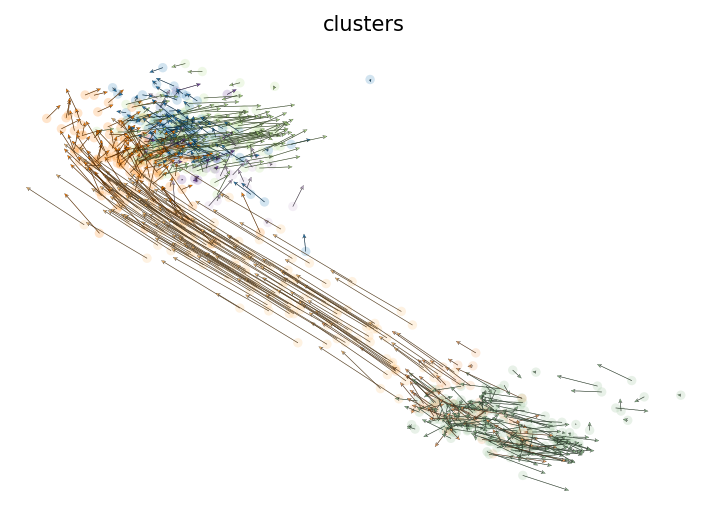

In [24]:
scv.tl.velocity_graph(adata)
scv.pl.velocity_embedding(adata, dpi = 150, basis='pca', arrow_length= 10)

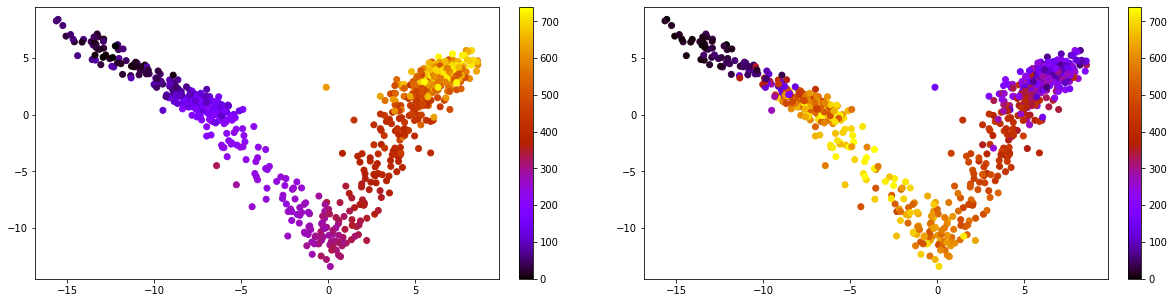

In [21]:
for idx, data in enumerate(DataLoader(pancreas)):
    pt = data.y_vdpt[0].squeeze()

    # pt = np.argsort(pt)
    X_pca = adata.obsm['X_umap']
    X_pca = utils.pca_op(data.x, standardize=False)
    fig = plt.figure(figsize = (20, 5))
    ax1,ax2 = fig.subplots(1,2)
    
    pred_sorted = sorted(pt)
    pt = [pred_sorted.index(i) for i in pt]

    pseudo_visual = ax1.scatter(-X_pca[:,0], -X_pca[:,1], c = pt, cmap = plt.get_cmap('gnuplot'))
    fig.colorbar(pseudo_visual,fraction=0.046, pad=0.04, ax = ax1)

    pt, _, _ = model(data.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
    pt = pt.detach().numpy().squeeze()

    pred_sorted = sorted(pt)
    pt = [pred_sorted.index(i) for i in pt]
    # pt = (pt - np.min(pt))/(np.max(pt)-np.min(pt))
    # print(len(pt))
    # pt = np.argsort(pt)
    
    pseudo_visual = ax2.scatter(-X_pca[:,0], -X_pca[:,1], c = pt, cmap = plt.get_cmap('gnuplot'))
    fig.colorbar(pseudo_visual,fraction=0.046, pad=0.04, ax = ax2)  

In [5]:
adata = anndata.read_h5ad('./data/real_dataset/chromaffin.h5ad')

scv.pp.filter_and_normalize(adata, flavor = 'cell_ranger', min_shared_counts=20, n_top_genes=301, log=True)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
scv.tl.velocity(adata, mode='stochastic') 
scv.tl.velocity_graph(adata)

Filtered out 9895 genes that are detected in less than 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
... 100%    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity graph
... 100%    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)


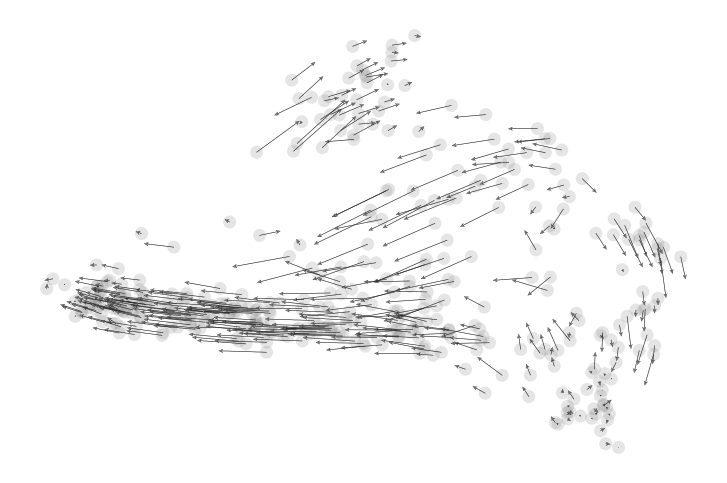

In [68]:
scv.tl.velocity_graph(adata)
scv.pl.velocity_embedding(adata, dpi = 150, basis='pca', arrow_length= 10)